In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
!pip install pydicom
from pydicom import dcmread
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from torch.utils import data

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download rsna-pneumonia-detection-challenge

100% 3.66G/3.66G [00:39<00:00, 109MB/s] 
100% 3.66G/3.66G [00:39<00:00, 100MB/s]


In [ ]:
! unzip rsna-pneumonia-detection-challenge

Streaming output truncated to the last 5000 lines.
  inflating: stage_2_train_images/d5252a78-3ea1-48e9-9ffb-e7535be3ce80.dcm  
  inflating: stage_2_train_images/d525eafb-8908-45fd-a942-48d07c435487.dcm  
  inflating: stage_2_train_images/d5265640-17db-4880-866d-d2952e32941c.dcm  
  inflating: stage_2_train_images/d5277276-f8f8-40e9-b8e1-791cf5d96ac0.dcm  
  inflating: stage_2_train_images/d528d9e9-647a-4e2e-a16c-bd5e32a5bbf5.dcm  
  inflating: stage_2_train_images/d5293a3e-f050-4b98-8bbf-1f40e25bced5.dcm  
  inflating: stage_2_train_images/d52cbb5a-1d0a-457d-8c72-0f7aeec21ca7.dcm  
  inflating: stage_2_train_images/d52ce67b-be7c-4349-8dc4-38562928d208.dcm  
  inflating: stage_2_train_images/d535a3c8-c4a4-4856-b5cd-17f6332eac8b.dcm  
  inflating: stage_2_train_images/d5360dc4-6bea-4a7b-bc49-5b2547ad7877.dcm  
  inflating: stage_2_train_images/d5364bc1-bc2a-4bd0-a1bd-0cfb5a369ccc.dcm  
  inflating: stage_2_train_images/d539e101-5662-445c-9f6a-381e674f0aed.dcm  
  inflating: stage_2_trai

## Data Preprocessing

In [ ]:
data = pd.read_csv('stage_2_train_labels.csv').filter(['patientId', 'Target'])
data.head(5)

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0
4,00436515-870c-4b36-a041-de91049b9ab4,1


In [ ]:
train_labels, val_labels = train_test_split(data.values, test_size=0.1)
print(train_labels.shape)
print(val_labels.shape)

(27204, 2)
(3023, 2)


In [ ]:
train_paths = [os.path.join('stage_2_train_images', image[0]) for image in train_labels]
val_paths = [os.path.join('stage_2_test_images', image[0]) for image in val_labels]

## Data Samples

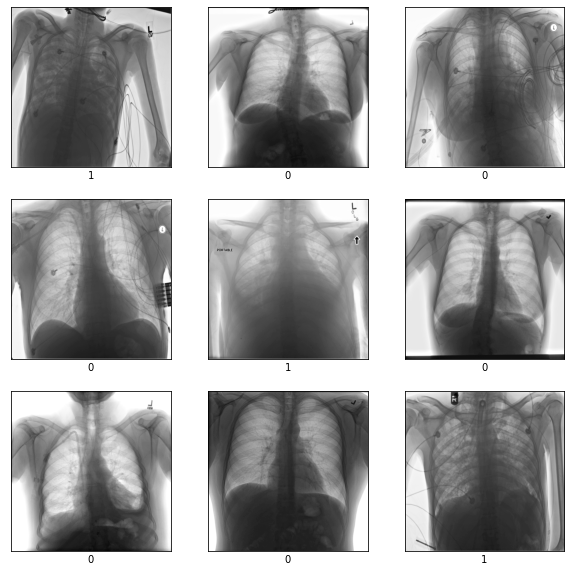

In [ ]:
def show(n=9):
    plt.figure(figsize=(10,10))
    for i in range(n):
        plt.xticks([])
        plt.yticks([])
        plt.subplot(3, 3, i+1)
        plt.grid(False)
        img_dcm = dcmread(f'{train_paths[i+20]}.dcm')
        plt.imshow(img_dcm.pixel_array, cmap=plt.cm.binary)
        plt.xlabel(train_labels[i+20][1])
show()

## Composing transformations

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.ToTensor()
])

## Formatted Dataset 

In [ ]:
class Dataset(data.Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
    
    def __getitem__(self, index):
        image = dcmread(f'{self.paths[index]}.dcm')
        image = image.pixel_array
        image = image / 255.0
        image = (255*image).clip(0, 255).astype(np.uint8)
        image = Image.fromarray(image).convert('RGB')
        label = self.labels[index][1]
        if self.transform is not None:
            image = self.transform(image)
        return image, label
        
    def __len__(self):
        return len(self.paths)

Tensor:tensor([[[0.6196, 0.6235, 0.5882,  ..., 0.0196, 0.0196, 0.0157],
         [0.4196, 0.4078, 0.3647,  ..., 0.0196, 0.0196, 0.0157],
         [0.1490, 0.1412, 0.1255,  ..., 0.0235, 0.0235, 0.0196],
         ...,
         [0.7804, 0.8275, 0.8314,  ..., 0.7725, 0.8118, 0.7922],
         [0.7843, 0.8275, 0.8353,  ..., 0.8627, 0.8667, 0.8157],
         [0.6667, 0.7059, 0.7098,  ..., 0.7373, 0.7333, 0.6902]],

        [[0.6196, 0.6235, 0.5882,  ..., 0.0196, 0.0196, 0.0157],
         [0.4196, 0.4078, 0.3647,  ..., 0.0196, 0.0196, 0.0157],
         [0.1490, 0.1412, 0.1255,  ..., 0.0235, 0.0235, 0.0196],
         ...,
         [0.7804, 0.8275, 0.8314,  ..., 0.7725, 0.8118, 0.7922],
         [0.7843, 0.8275, 0.8353,  ..., 0.8627, 0.8667, 0.8157],
         [0.6667, 0.7059, 0.7098,  ..., 0.7373, 0.7333, 0.6902]],

        [[0.6196, 0.6235, 0.5882,  ..., 0.0196, 0.0196, 0.0157],
         [0.4196, 0.4078, 0.3647,  ..., 0.0196, 0.0196, 0.0157],
         [0.1490, 0.1412, 0.1255,  ..., 0.0235, 0.0

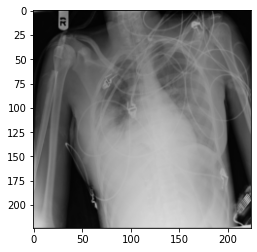

In [ ]:
train_dataset = Dataset(train_paths, train_labels, transform=transform)
image = iter(train_dataset)
img, label = next(image)
print(f'Tensor:{img}, Label:{label}')
img = np.transpose(img, (1, 2, 0))
plt.imshow(img)

## Train image shape

In [ ]:
img.shape

torch.Size([224, 224, 3])

## Load Training and Testing Dataset

In [ ]:
train_dataset = Dataset(train_paths, train_labels, transform=transform)
val_dataset = Dataset(val_paths, val_labels, transform=transform)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

## Check dataloader

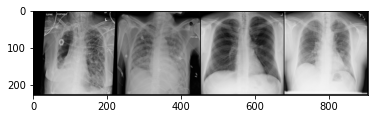

In [ ]:
batch = iter(train_loader)
images, labels = next(batch)

image_grid = torchvision.utils.make_grid(images[:4])
image_np = image_grid.numpy()
img = np.transpose(image_np, (1, 2, 0))
plt.imshow(img)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
!nvidia-smi

Sun Apr 24 22:12:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load Untrained SwinTransformer

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 5.2 MB/s 
     |████████████████████████████████| 895 kB 86.7 MB/s 
     |████████████████████████████████| 77 kB 9.3 MB/s 
     |████████████████████████████████| 6.6 MB 81.7 MB/s 
     |████████████████████████████████| 596 kB 87.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install timm

     |████████████████████████████████| 431 kB 5.3 MB/s 


In [ ]:
# --------------------------------------------------------
# Swin Transformer
# Copyright (c) 2021 Microsoft
# Licensed under The MIT License [see LICENSE for details]
# Written by Ze Liu
# --------------------------------------------------------
!pip install timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from timm.models.layers import DropPath, to_2tuple, trunc_normal_


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size
    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image
    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class SwinMLPBlock(nn.Module):
    r""" Swin MLP Block.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        drop (float, optional): Dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.padding = [self.window_size - self.shift_size, self.shift_size,
                        self.window_size - self.shift_size, self.shift_size]  # P_l,P_r,P_t,P_b

        self.norm1 = norm_layer(dim)
        # use group convolution to implement multi-head MLP
        self.spatial_mlp = nn.Conv1d(self.num_heads * self.window_size ** 2,
                                     self.num_heads * self.window_size ** 2,
                                     kernel_size=1,
                                     groups=self.num_heads)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # shift
        if self.shift_size > 0:
            P_l, P_r, P_t, P_b = self.padding
            shifted_x = F.pad(x, [0, 0, P_l, P_r, P_t, P_b], "constant", 0)
        else:
            shifted_x = x
        _, _H, _W, _ = shifted_x.shape

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # Window/Shifted-Window Spatial MLP
        x_windows_heads = x_windows.view(-1, self.window_size * self.window_size, self.num_heads, C // self.num_heads)
        x_windows_heads = x_windows_heads.transpose(1, 2)  # nW*B, nH, window_size*window_size, C//nH
        x_windows_heads = x_windows_heads.reshape(-1, self.num_heads * self.window_size * self.window_size,
                                                  C // self.num_heads)
        spatial_mlp_windows = self.spatial_mlp(x_windows_heads)  # nW*B, nH*window_size*window_size, C//nH
        spatial_mlp_windows = spatial_mlp_windows.view(-1, self.num_heads, self.window_size * self.window_size,
                                                       C // self.num_heads).transpose(1, 2)
        spatial_mlp_windows = spatial_mlp_windows.reshape(-1, self.window_size * self.window_size, C)

        # merge windows
        spatial_mlp_windows = spatial_mlp_windows.reshape(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(spatial_mlp_windows, self.window_size, _H, _W)  # B H' W' C

        # reverse shift
        if self.shift_size > 0:
            P_l, P_r, P_t, P_b = self.padding
            x = shifted_x[:, P_t:-P_b, P_l:-P_r, :].contiguous()
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W

        # Window/Shifted-Window Spatial MLP
        if self.shift_size > 0:
            nW = (H / self.window_size + 1) * (W / self.window_size + 1)
        else:
            nW = H * W / self.window_size / self.window_size
        flops += nW * self.dim * (self.window_size * self.window_size) * (self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops


class PatchMerging(nn.Module):
    r""" Patch Merging Layer.
    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops


class BasicLayer(nn.Module):
    """ A basic Swin MLP layer for one stage.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        drop (float, optional): Dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., drop=0., drop_path=0.,
                 norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinMLPBlock(dim=dim, input_resolution=input_resolution,
                         num_heads=num_heads, window_size=window_size,
                         shift_size=0 if (i % 2 == 0) else window_size // 2,
                         mlp_ratio=mlp_ratio,
                         drop=drop,
                         drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                         norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops


class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding
    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        Ho, Wo = self.patches_resolution
        flops = Ho * Wo * self.embed_dim * self.in_chans * (self.patch_size[0] * self.patch_size[1])
        if self.norm is not None:
            flops += Ho * Wo * self.embed_dim
        return flops


class SwinMLP(nn.Module):
    r""" Swin MLP
    Args:
        img_size (int | tuple(int)): Input image size. Default 224
        patch_size (int | tuple(int)): Patch size. Default: 4
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin MLP layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        drop_rate (float): Dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, num_classes=1000,
                 embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
                 window_size=7, mlp_ratio=4., drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, **kwargs):
        super().__init__()

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                               input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                                 patches_resolution[1] // (2 ** i_layer)),
                               depth=depths[i_layer],
                               num_heads=num_heads[i_layer],
                               window_size=window_size,
                               mlp_ratio=self.mlp_ratio,
                               drop=drop_rate,
                               drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                               norm_layer=norm_layer,
                               downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                               use_checkpoint=use_checkpoint)
            self.layers.append(layer)

        self.norm = norm_layer(self.num_features)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, (nn.Linear, nn.Conv1d)):
            trunc_normal_(m.weight, std=.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def forward_features(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x)

        x = self.norm(x)  # B L C
        x = self.avgpool(x.transpose(1, 2))  # B C 1
        x = torch.flatten(x, 1)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

    def flops(self):
        flops = 0
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += self.num_features * self.patches_resolution[0] * self.patches_resolution[1] // (2 ** self.num_layers)
        flops += self.num_features * self.num_classes
        return flops

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoFeatureExtractor, SwinModel, SwinConfig
from timm import create_model
model = SwinMLP(num_classes=2, depths=[2, 2, 18, 2])

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [ ]:
# model.encoder.layers[3].blocks[1].output.dense = nn.Linear(in_features=3072, out_features=2, bias=True)
#model.layernorm=nn.LayerNorm((768,2), eps=1e-05, elementwise_affine=True)

In [ ]:
model.to(device)

SwinMLP(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): BasicLayer(
      dim=96, input_resolution=(56, 56), depth=2
      (blocks): ModuleList(
        (0): SwinMLPBlock(
          dim=96, input_resolution=(56, 56), num_heads=3, window_size=7, shift_size=0, mlp_ratio=4.0
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (spatial_mlp): Conv1d(147, 147, kernel_size=(1,), stride=(1,), groups=3)
          (drop_path): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU()
            (fc2): Linear(in_features=384, out_features=96, bias=True)
            (drop): Dropout(p=0.0, inplace=False)
          )
        )
        (1): Sw

## Write a train code and RUN

In [ ]:
torch.cuda.empty_cache()
# Train the model
total_step = len(train_loader)
for epoch in range(10):
    # Training
    for i, (images, labels) in tqdm(enumerate(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        predictions = model(images)
        loss = criterion(predictions, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 2000 == 0:
            print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(epoch+1, num_epochs, i+1, total_step, loss.item()))


    # Validation
    correct = 0
    total = 0  
    for images, labels in tqdm(val_loader):
        images = images.to(device)
        labels = labels.to(device)
        predictions = model(images)
        _, predicted = torch.max(predictions, 1)
        total += labels.size(0)
        correct += (labels == predicted).sum()
    print(f'Epoch: {epoch+1}/{num_epochs}, Val_Acc: {100*correct/total}')

851it [15:11,  1.07s/it]
100%|██████████| 95/95 [01:06<00:00,  1.43it/s]


Epoch: 1/10, Val_Acc: 77.43962860107422


851it [15:11,  1.07s/it]
100%|██████████| 95/95 [01:06<00:00,  1.43it/s]


Epoch: 2/10, Val_Acc: 78.00198364257812


851it [15:17,  1.08s/it]
100%|██████████| 95/95 [01:07<00:00,  1.42it/s]


Epoch: 3/10, Val_Acc: 78.7628173828125


851it [15:14,  1.07s/it]
100%|██████████| 95/95 [01:06<00:00,  1.43it/s]


Epoch: 4/10, Val_Acc: 78.729736328125


851it [15:15,  1.08s/it]
100%|██████████| 95/95 [01:06<00:00,  1.43it/s]


Epoch: 5/10, Val_Acc: 79.06053924560547


851it [15:09,  1.07s/it]
100%|██████████| 95/95 [01:04<00:00,  1.48it/s]


Epoch: 6/10, Val_Acc: 78.99437713623047


851it [14:47,  1.04s/it]
100%|██████████| 95/95 [01:03<00:00,  1.50it/s]


Epoch: 7/10, Val_Acc: 79.58981323242188


851it [15:01,  1.06s/it]
100%|██████████| 95/95 [01:05<00:00,  1.46it/s]


Epoch: 8/10, Val_Acc: 79.06053924560547


851it [15:01,  1.06s/it]
100%|██████████| 95/95 [01:06<00:00,  1.44it/s]


Epoch: 9/10, Val_Acc: 79.92060852050781


851it [15:01,  1.06s/it]
100%|██████████| 95/95 [01:03<00:00,  1.49it/s]

Epoch: 10/10, Val_Acc: 80.28448486328125


In [ ]:
#torch.save(model.state_dict(), "swinTransformer.pt")

In [ ]:
# swin = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=2)
# # Here the size of each output sample is set to 2.
# # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# swin.to(device)
# swin.load_state_dict(torch.load("swinTransformer.pt"))

In [ ]:
# print(torch.__version__)

In [ ]:
# swin.eval()


# correct = 0
# total = 0  
# for images, labels in tqdm(train_loader):
#     images = images.to(device)
#     labels = labels.to(device)
#     predictions = swin(images)
#     _, predicted = torch.max(predictions, 1)
#     total += labels.size(0)
#     correct += (labels == predicted).sum()
# print(f'Val_Acc: {100*correct/total}')

In [ ]:
swin=model

## Test model

In [ ]:
swin.eval()
preds = []
labels = []
with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.max(swin(data),1)[1].item()
        preds.append(pred)
        labels.append(label)

100%|██████████| 3023/3023 [01:52<00:00, 26.86it/s]


In [ ]:
preds.count(preds[0]) == len(preds)

False

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
acc = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)
cm = confusion_matrix(labels, preds)

print(f"Val Accuracy {acc}")
print(f"Val precision {precision}")
print(f"Val Recall {recall}")
print(f"Val F1 {f1}")
print(f"Confusion Matrix {cm}")

Val Accuracy 0.8094608005292756
Val precision 0.7276995305164319
Val Recall 0.6431535269709544
Val F1 0.6828193832599119
Confusion Matrix [[1827  232]
 [ 344  620]]
